In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Configuración para visualizaciones
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [4]:
# Cargar datos
df = pd.read_csv("../brain_stroke_plus.csv")
print('Dimensiones del dataset:', df.shape)
df.head()

Dimensiones del dataset: (5516, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,Unknown,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0


In [5]:
# Preprocesamiento de datos
# 1. Manejar valores nulos
df['smoking_status'] = df['smoking_status'].fillna('Unknown')
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# 2. Codificación de variables categóricas
le = LabelEncoder()
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for column in categorical_columns:
    df[column + '_encoded'] = le.fit_transform(df[column])

# 3. Selección de características
features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'] + [col + '_encoded' for col in categorical_columns]

X = df[features]
y = df['stroke']

# 4. Escalado de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. División de datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

Resultados del modelo Random Forest:
Accuracy: 0.8614130434782609
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       947
           1       0.52      0.27      0.36       157

    accuracy                           0.86      1104
   macro avg       0.71      0.62      0.64      1104
weighted avg       0.84      0.86      0.84      1104



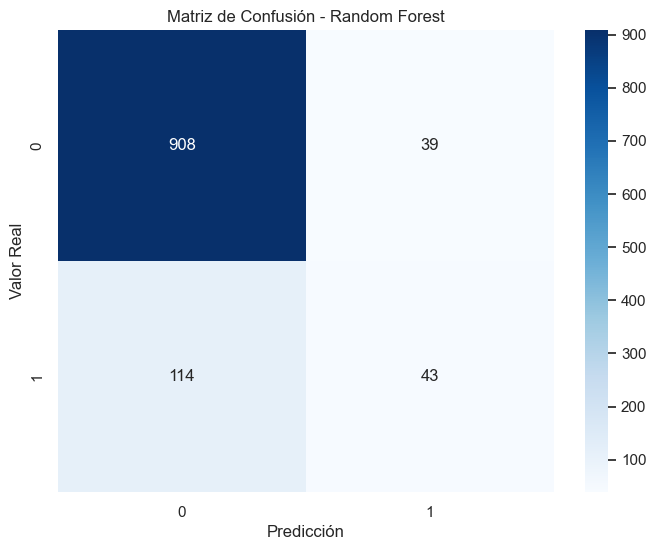

In [6]:
# Entrenamiento y evaluación del modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluación
print('Resultados del modelo Random Forest:')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Reporte de clasificación:')
print(classification_report(y_test, y_pred_rf))

# Matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

Resultados del modelo Gradient Boosting:
Accuracy: 0.8786231884057971
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       947
           1       0.68      0.28      0.40       157

    accuracy                           0.88      1104
   macro avg       0.78      0.63      0.66      1104
weighted avg       0.86      0.88      0.86      1104



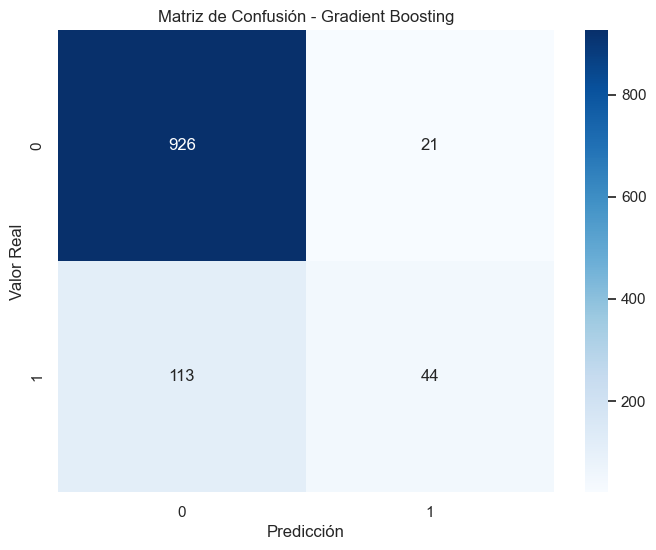

In [7]:
# Entrenamiento y evaluación del modelo Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predicciones
y_pred_gb = gb_model.predict(X_test)

# Evaluación
print('Resultados del modelo Gradient Boosting:')
print('Accuracy:', accuracy_score(y_test, y_pred_gb))
print('Reporte de clasificación:')
print(classification_report(y_test, y_pred_gb))

# Matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Gradient Boosting')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

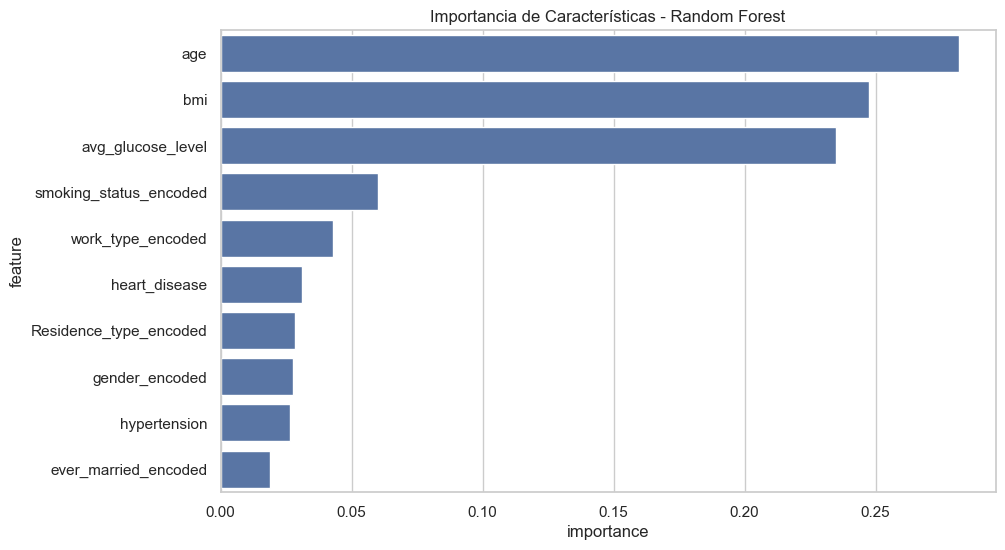

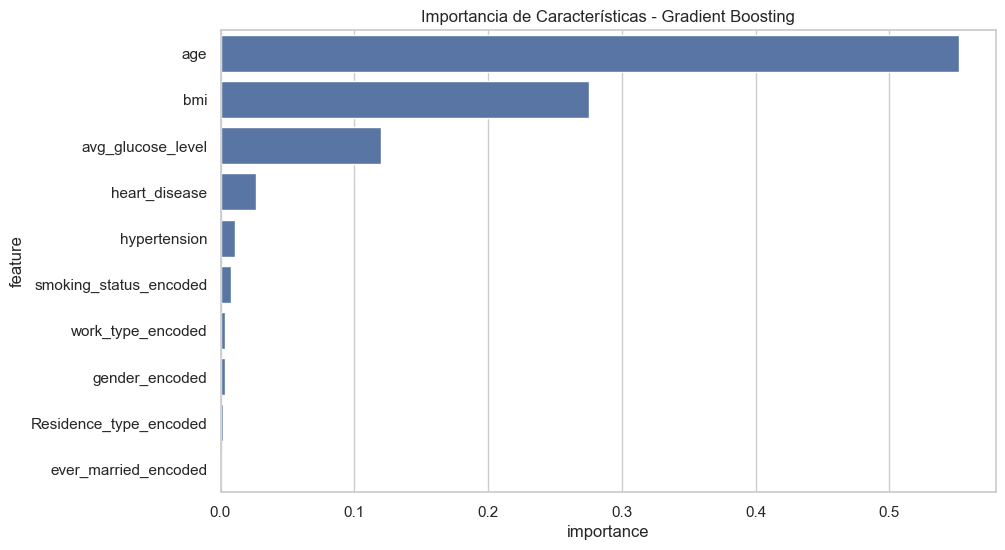

In [8]:
# Importancia de características
feature_importance_rf = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_rf)
plt.title('Importancia de Características - Random Forest')
plt.show()

feature_importance_gb = pd.DataFrame({
    'feature': features,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_gb)
plt.title('Importancia de Características - Gradient Boosting')
plt.show()

In [9]:
# Validación cruzada
cv_scores_rf = cross_val_score(rf_model, X_scaled, y, cv=5)
cv_scores_gb = cross_val_score(gb_model, X_scaled, y, cv=5)

print('Resultados de validación cruzada (5-fold):')
print('Random Forest - Media:', cv_scores_rf.mean(), 'Desviación estándar:', cv_scores_rf.std())
print('Gradient Boosting - Media:', cv_scores_gb.mean(), 'Desviación estándar:', cv_scores_gb.std())

Resultados de validación cruzada (5-fold):
Random Forest - Media: 0.8616756671528243 Desviación estándar: 0.004869732207042685
Gradient Boosting - Media: 0.8740015701578041 Desviación estándar: 0.0038015277747767036


In [10]:
# Crear y entrenar el modelo Gradient Boosting
gb_classifier = GradientBoostingClassifier(random_state=42)

# Optimización de hiperparámetros
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

grid_search_gb = GridSearchCV(gb_classifier, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

best_gb_model = grid_search_gb.best_estimator_
print('Mejores parámetros para Gradient Boosting:', grid_search_gb.best_params_)
print('Mejor puntuación de validación:', grid_search_gb.best_score_)

# Evaluación del modelo optimizado
y_pred_gb = best_gb_model.predict(X_test)
print('Informe de clasificación del modelo optimizado:')
print(classification_report(y_test, y_pred_gb))

# Guardar el modelo optimizado
model_filename = 'stroke_prediction_model.pkl'
joblib.dump(best_gb_model, model_filename)
print(f'Modelo guardado como: {model_filename}')

Mejores parámetros para Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Mejor puntuación de validación: 0.8791914802916259
Informe de clasificación del modelo optimizado:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       947
           1       0.69      0.28      0.40       157

    accuracy                           0.88      1104
   macro avg       0.79      0.63      0.67      1104
weighted avg       0.86      0.88      0.86      1104

Modelo guardado como: stroke_prediction_model.pkl
